In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
df = pd.read_csv('/Users/pratikkapse/MachineLearningLab/Product_Demand_Forecasting/Historical Product Demand.csv')
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


In [6]:
df.Product_Code.nunique()

2160

In [7]:
df.Warehouse.nunique()

4

In [8]:
df.Product_Category.nunique()

33

In [9]:
df.Date.nunique()

1729

In [10]:
def check_order_demand(x):
    try:
        int(x)
    except:
        return False
    return True

In [11]:
def change_to_int(x):
    try:
        #return int(x)
        return int(x[1:-1])
    except:
        #return int(x[1:-1])
        return False

In [12]:
df['Order_Demand'] = df['Order_Demand'].apply(lambda x: int(x) if check_order_demand(x) else change_to_int(x))

In [13]:
df.describe()

,Order_Demand
count,1.048575e+06
mean,4.906977e+03
std,2.892678e+04
min,0.000000e+00
25%,2.000000e+01
50%,3.000000e+02
75%,2.000000e+03
max,4.000000e+06


In [14]:
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [15]:
df = df.dropna()

In [16]:
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

In [17]:
def extract_date_features(dataframe):
    dataframe = dataframe.copy()
    dataframe['day_of_the_week'] = dataframe.index.dayofweek
    dataframe['Quarter'] = dataframe.index.quarter
    dataframe['Month'] = dataframe.index.month
    dataframe['Year'] = dataframe.index.year
    dataframe['Week'] = dataframe.index.isocalendar().week.astype(int)
    return dataframe

df = extract_date_features(df)
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Order_Demand         int64
day_of_the_week      int64
Quarter              int64
Month                int64
Year                 int64
Week                 int64
dtype: object

In [18]:
X = ['day_of_the_week', 'Quarter', 'Month', 'Year', 'Week']
y = ['Order_Demand']

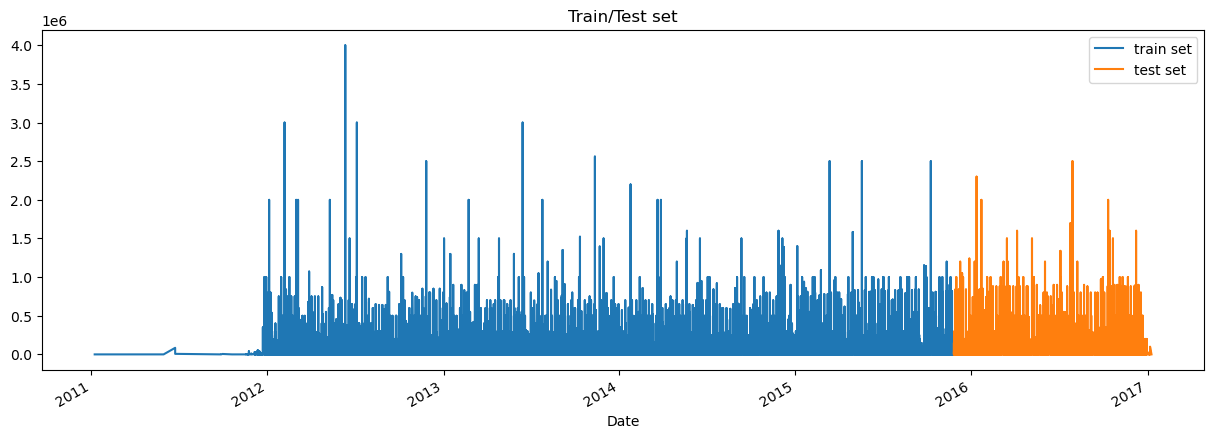

In [19]:
# Convert index to datetime format
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Create train and test sets based on date
train_df, test_df = train_test_split(df, train_size = 0.8, test_size = 0.2, shuffle = False)

# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
train_df['Order_Demand'].plot(ax=ax, label='train set', legend=True, title='Train/Test set')
test_df['Order_Demand'].plot(ax=ax, label='test set', legend=True)
plt.show()


In [20]:
X_train = train_df[X]
X_test = test_df[X]

y_train = train_df[y]
y_test = test_df[y]

In [21]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators = 5000, 
                     early_stopping_rounds = 100,
                    learning_rate = 0.01).fit(X_train, y_train,
                    eval_set = [(X_train,y_train), (X_test,y_test)],
                    verbose = 50)

[0]	validation_0-rmse:28676.72900	validation_1-rmse:30606.98828
[50]	validation_0-rmse:28661.39536	validation_1-rmse:30591.15477
[100]	validation_0-rmse:28654.52995	validation_1-rmse:30589.25493
[150]	validation_0-rmse:28650.43898	validation_1-rmse:30591.53119
[197]	validation_0-rmse:28647.96091	validation_1-rmse:30591.16861


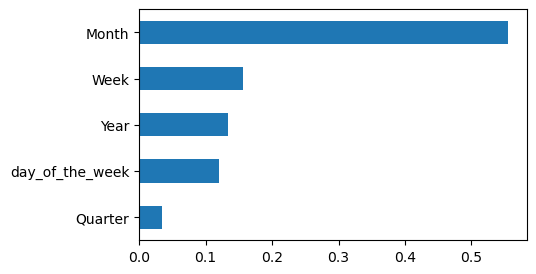

In [42]:
imp_features = pd.DataFrame(model.feature_importances_, index = X, columns = ['feature_importance'])
imp_features.feature_importance.sort_values().plot(kind = 'barh', figsize =(5,3))
plt.show()

In [30]:
new_df = df[df.index >= '2012-01-01']

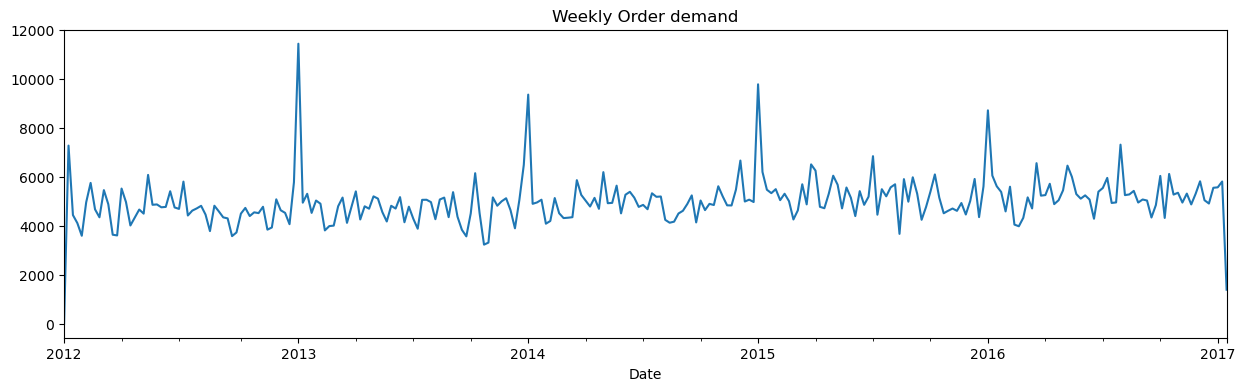

In [31]:
# Resample data as Weekly 
df_week = new_df.resample('W').mean()
df_week['Order_Demand'].plot(figsize = (15,4), title = 'Weekly Order demand')
plt.show()

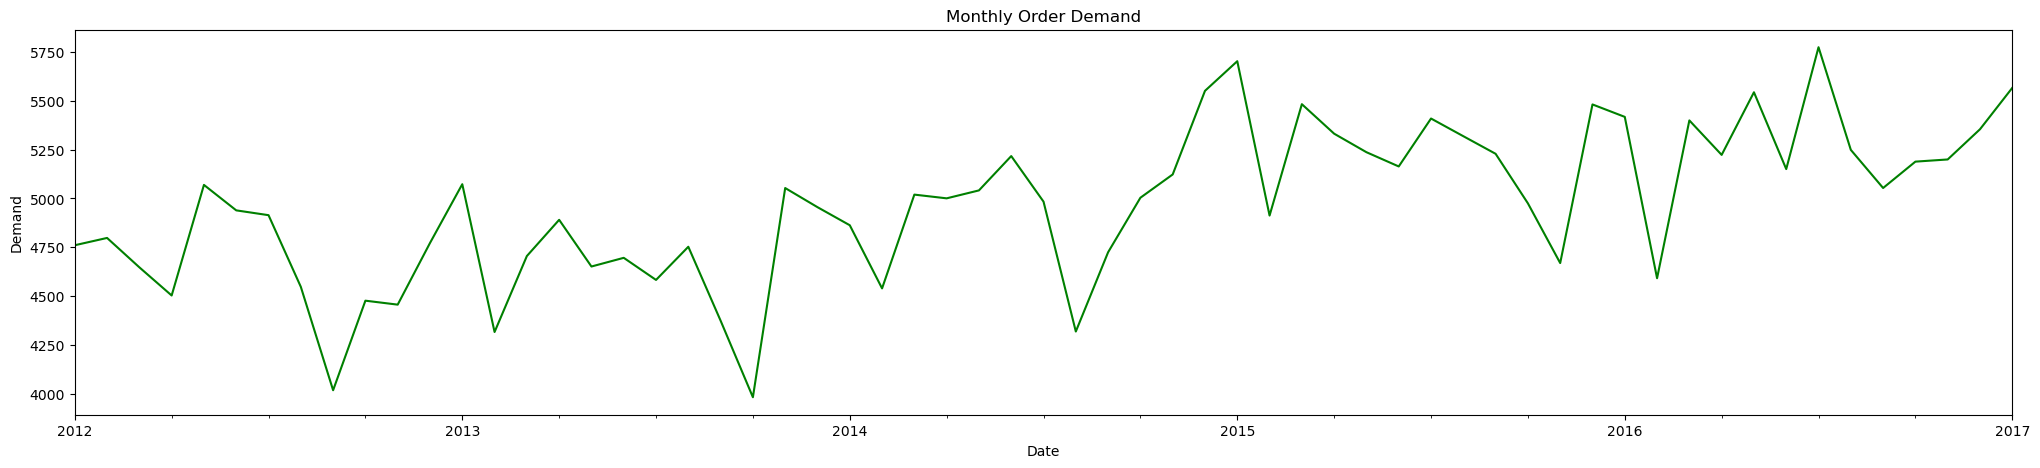

In [32]:
#Time Series Analysis
df_month = new_df.resample('MS').mean()
df_month.Order_Demand.plot(figsize = (25,5), title = 'Monthly Order Demand', color = 'green')
plt.ylabel('Demand')
plt.show()

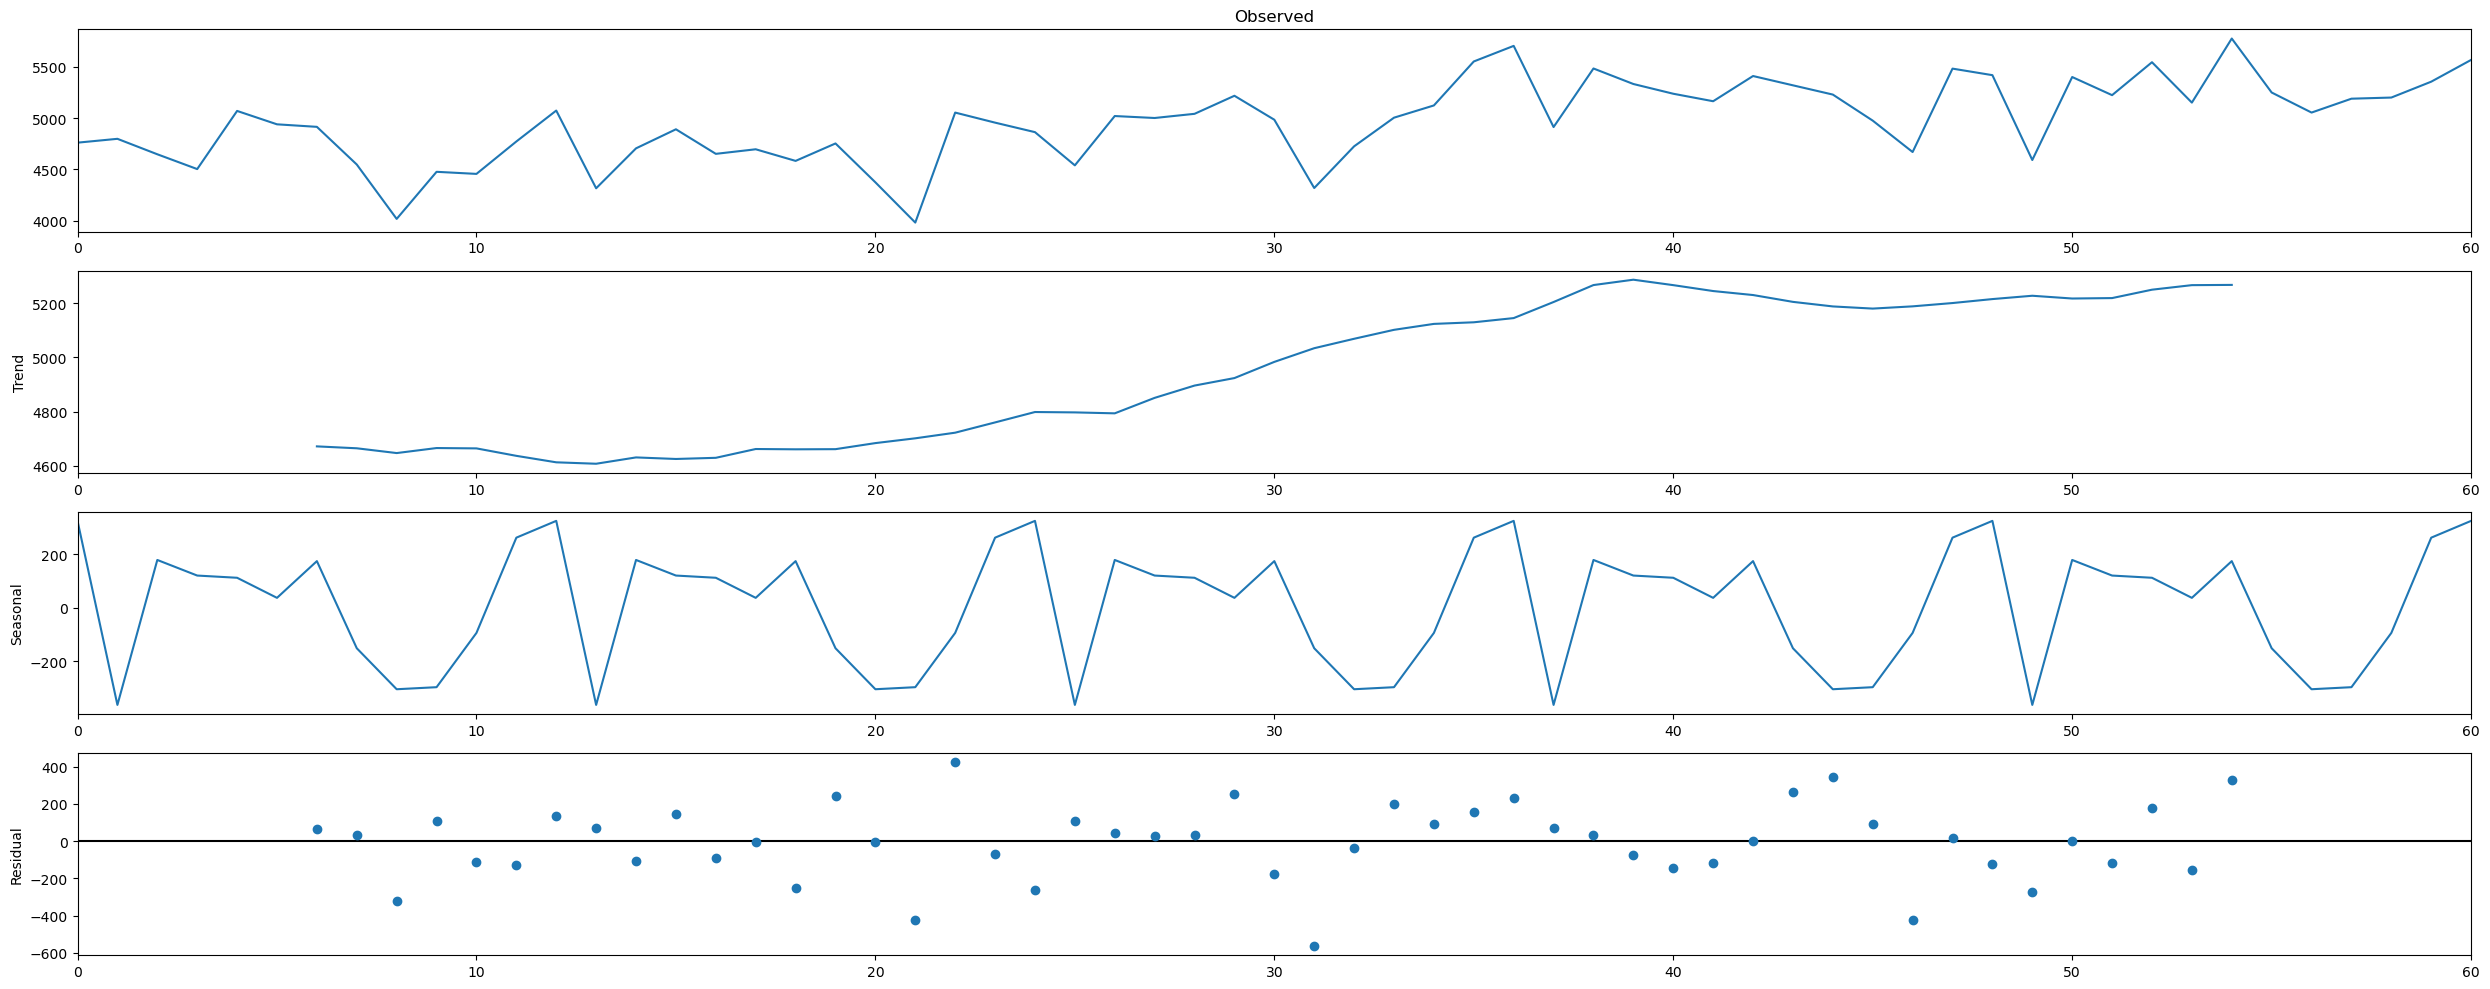

In [33]:
rcParams['figure.figsize'] = 25, 10
decomposition = seasonal_decompose(df_month.Order_Demand.values, model='additive', period = 12)
                   
fig = decomposition.plot()
plt.show()

In [34]:
adfuller(df_month['Order_Demand'])

(-2.1353562491537046,
 0.23053730809929224,
 2,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 714.3239865088049)

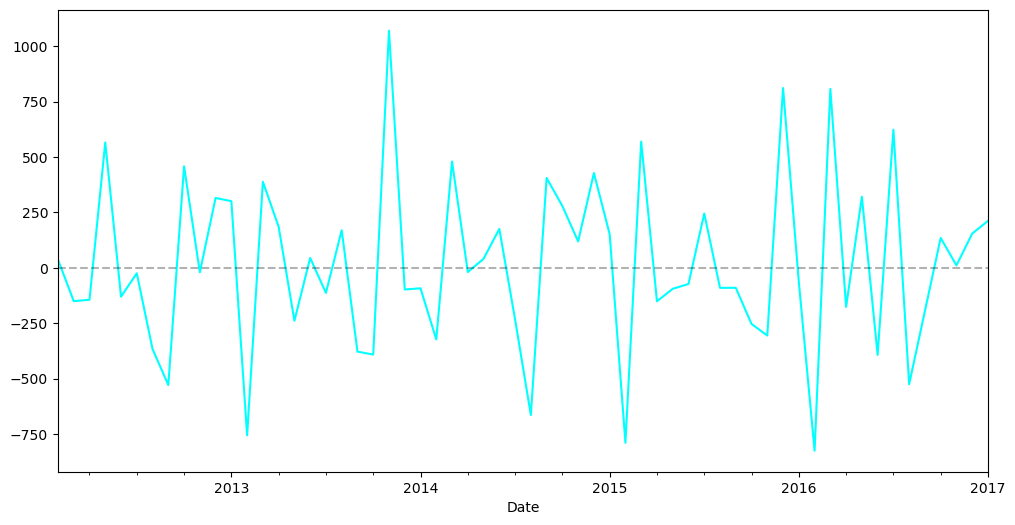

In [35]:
# Take First Difference to Remove Trend
df_diff = df_month.Order_Demand.diff()[1:]
df_diff.plot(figsize=(12,6), color = 'cyan')
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

In [36]:
# Augmented Dicker Fuller Test to check if this new series is stationnary after differentiation
adfuller(df_diff)

(-6.758687705873297,
 2.8284296959133243e-09,
 2,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 700.6632081217224)

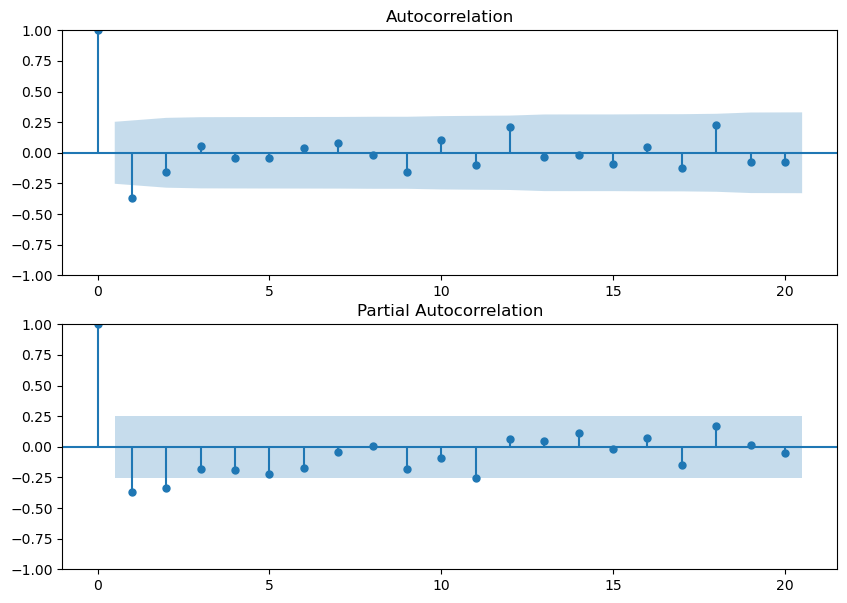

In [37]:
fig = plt.figure(figsize = (10,7))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_diff, lags = 20, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_diff, lags = 20, method='ywm', ax = ax2)
plt.show()

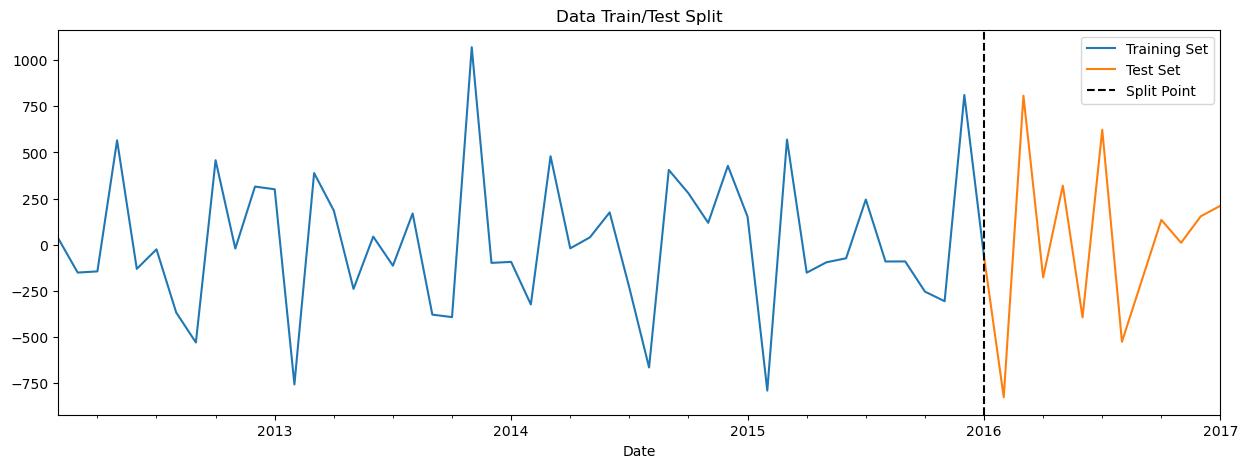

In [38]:
train_end = datetime(2016,1,1)
test_end = datetime(2017,1,1)

df_train = df_diff[:train_end]
df_test = df_diff[train_end:test_end]

# plot train and test dataset on the same graph
fig, ax = plt.subplots(figsize=(15, 5))
df_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
df_test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set','Split Point'])
plt.show()

In [39]:
model_arima = ARIMA(df_train, order = (2,1,1)).fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:           Order_Demand   No. Observations:                   48
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -343.242
Date:                Tue, 28 Nov 2023   AIC                            694.484
Time:                        12:23:12   BIC                            701.885
Sample:                    02-01-2012   HQIC                           697.269
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3710      0.168     -2.211      0.027      -0.700      -0.042
ar.L2         -0.3259      0.184     -1.768      0.077      -0.687       0.035
ma.L1         -0.9999      0.252     -3.964      0.0

In [40]:
# get the predictions start and end dates
pred_start = df_test.index[0]
pred_end= df_test.index[-1]

# Make predictions
prediction = model_arima.predict(start = pred_start, end = pred_end)

# Get the residuals
residuals = df_test - prediction

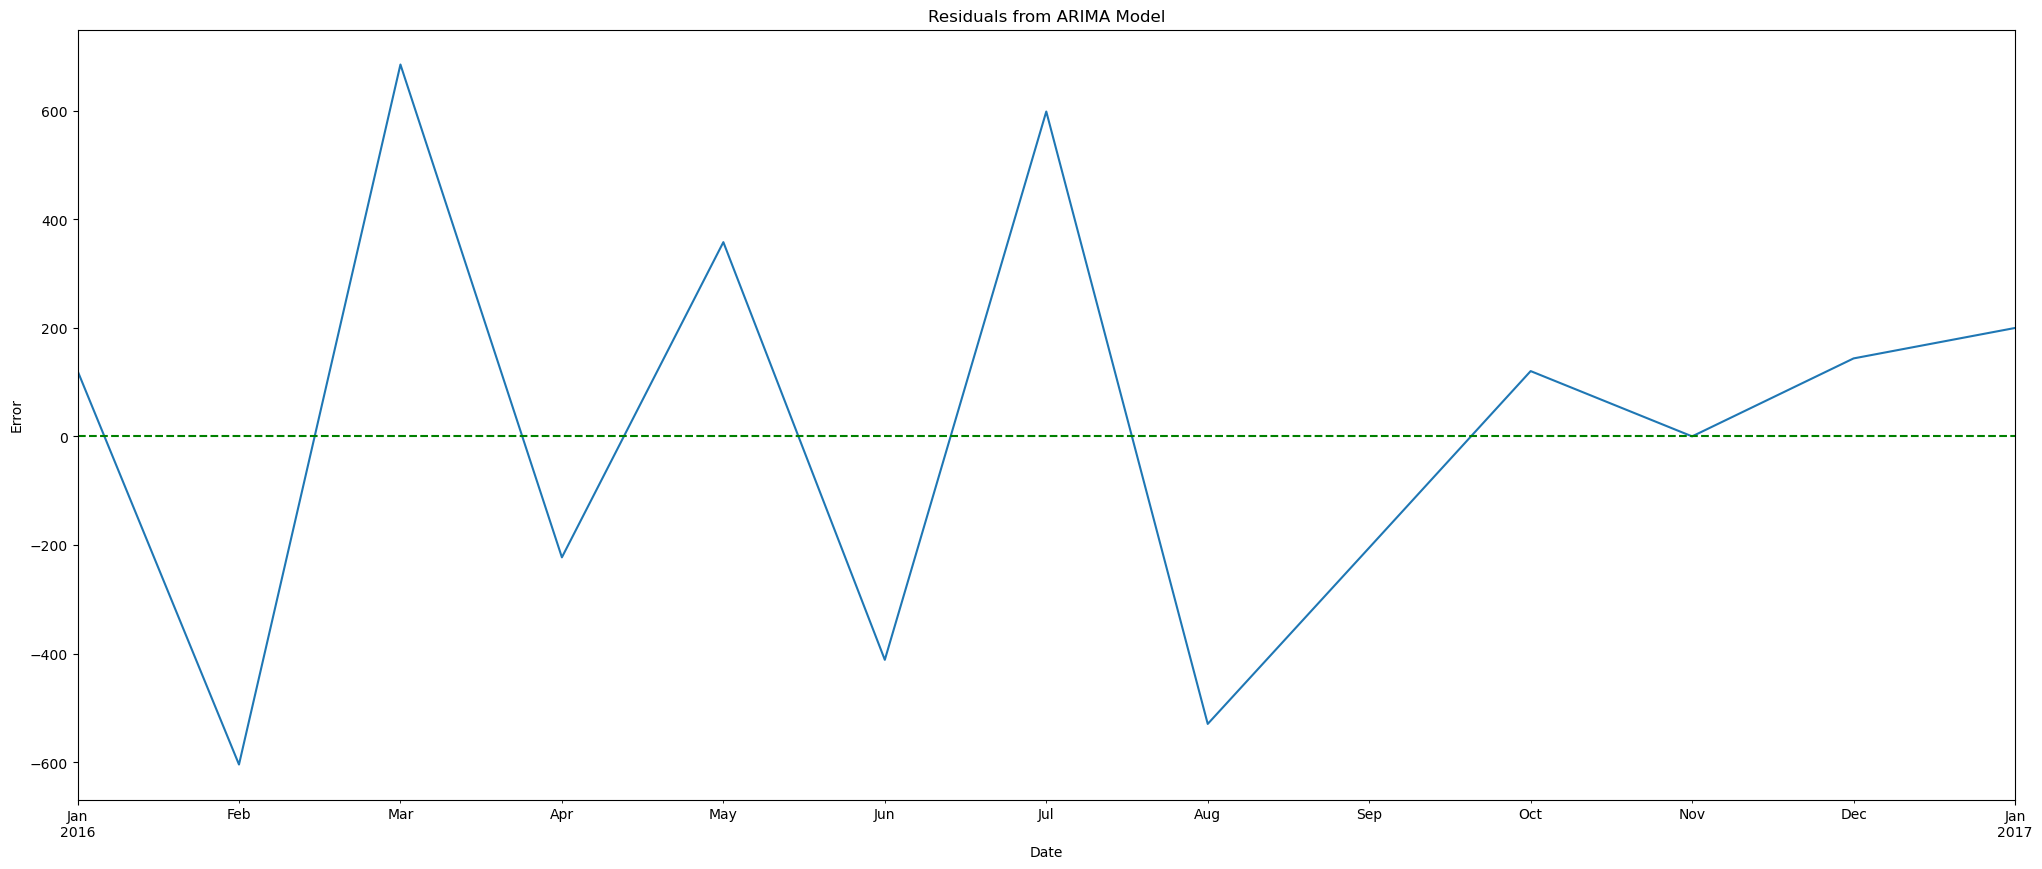

In [41]:
# Plot the residuals
residuals.plot(kind = 'line', title = 'Residuals from ARIMA Model')
plt.axhline(0,color ='g', linestyle = '--')
plt.ylabel('Error')
plt.show()

In [42]:
rmse = np.sqrt(np.mean(residuals**2))

In [43]:
rmse

387.30403267858975

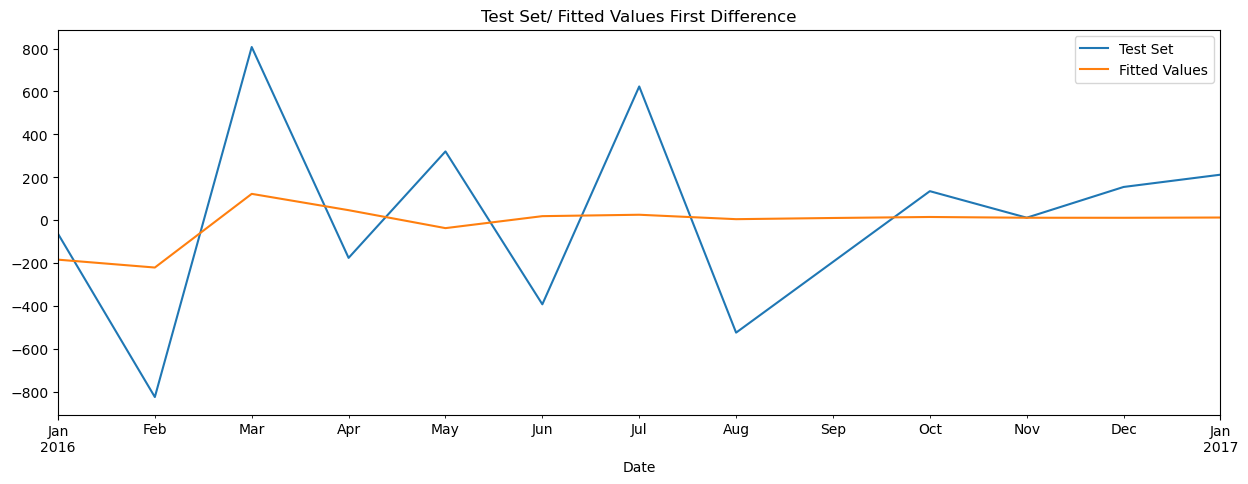

In [44]:
# Plot the train set against the predicted values
fig, ax = plt.subplots(figsize=(15, 5))
df_test.plot(ax=ax, label='Training Set', title='Test Set/ Fitted Values First Difference')
prediction.plot(ax=ax, label='Prediction')
ax.legend(['Test Set', 'Fitted Values'])
plt.show()

In [45]:
model_sarima =SARIMAX(df_train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
print(model_sarima.summary().tables[1])
pred = model_sarima.predict(start = pred_start, end = pred_end)

/Users/pratikkapse/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35043D+00    |proj g|=  2.04028D-01

At iterate    5    f=  3.29415D+00    |proj g|=  4.57071D-03

At iterate   10    f=  3.29401D+00    |proj g|=  4.42399D-04

At iterate   15    f=  3.29390D+00    |proj g|=  1.13908D-02

At iterate   20    f=  3.28326D+00    |proj g|=  9.12253D-02

At iterate   25    f=  3.21163D+00    |proj g|=  3.50077D-02

At iterate   30    f=  3.20873D+00    |proj g|=  3.84539D-03

At iterate   35    f=  3.20853D+00    |proj g|=  7.10302D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

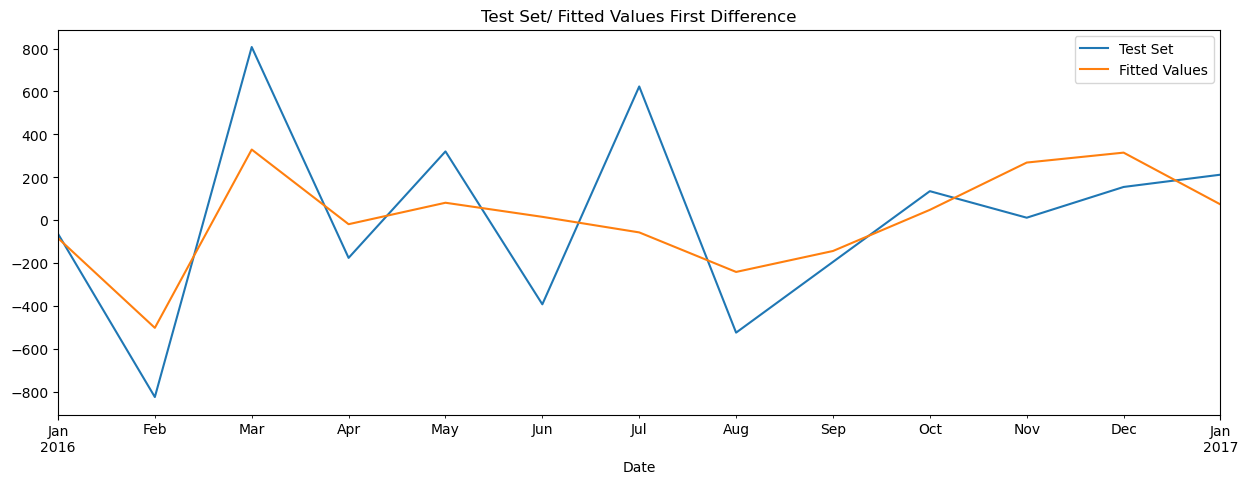

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))
df_test.plot(ax=ax, label='Training Set', title='Test Set/ Fitted Values First Difference')
pred.plot(ax=ax, label='Prediction')
ax.legend(['Test Set', 'Fitted Values'])
plt.show()

In [47]:
res = df_test - pred
rmse = np.sqrt(np.mean(res**2))
rmse

309.6197257642476

In [48]:
# Getting only the value of zeroth index since the diff() operation looses first value.
pred.iloc[0] = df_month.query('index == "2016-01-01"')['Order_Demand']
#cumsum Return cumulative sum over a DataFrame or Series axis
model_predicted = pred.cumsum()
model_predicted.head()

2016-01-01    5416.990630
2016-02-01    4914.334262
2016-03-01    5243.311593
2016-04-01    5224.125934
2016-05-01    5304.983633
Freq: MS, Name: predicted_mean, dtype: float64

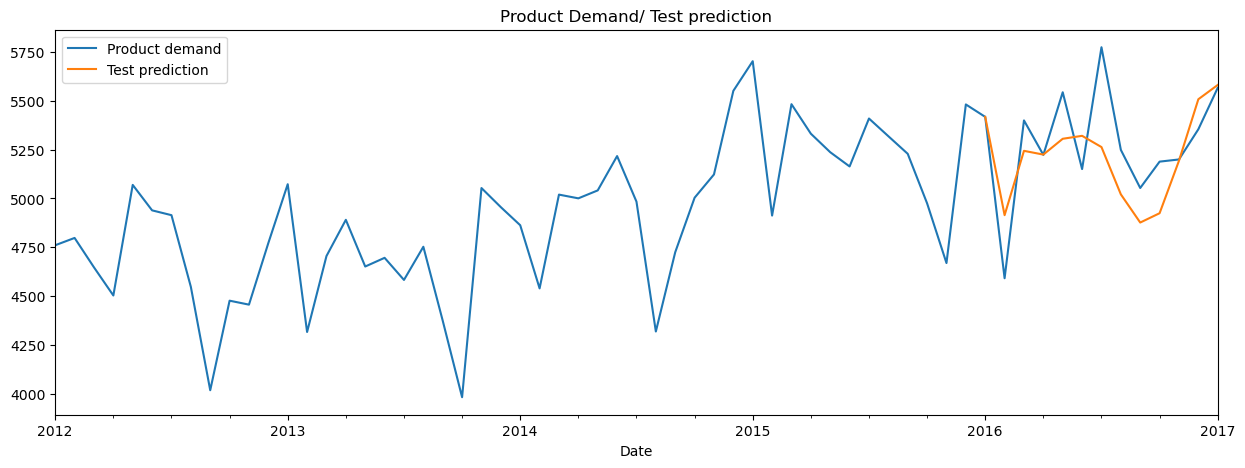

In [49]:
# Plot the actual data set and the actual predicted values
fig, ax = plt.subplots(figsize=(15, 5))
df_month.Order_Demand.plot(ax=ax, label='Product Demand', title='Product Demand/ Test prediction')
model_predicted.plot(ax=ax, label='Test prediction')
ax.legend(['Product demand', 'Test prediction'])
plt.show()

In [50]:
# predict Demand for the next year
future = model_sarima.predict(start = '2017-01-01', end = '2017-12-01')
# Getting only the value of zeroth index since the diff() operation looses first value.
future.iloc[0] = df_month.query('index == "2017-01-01"')['Order_Demand']
#cumsum Return cumulative sum over a DataFrame or Series axis
future = future.cumsum()

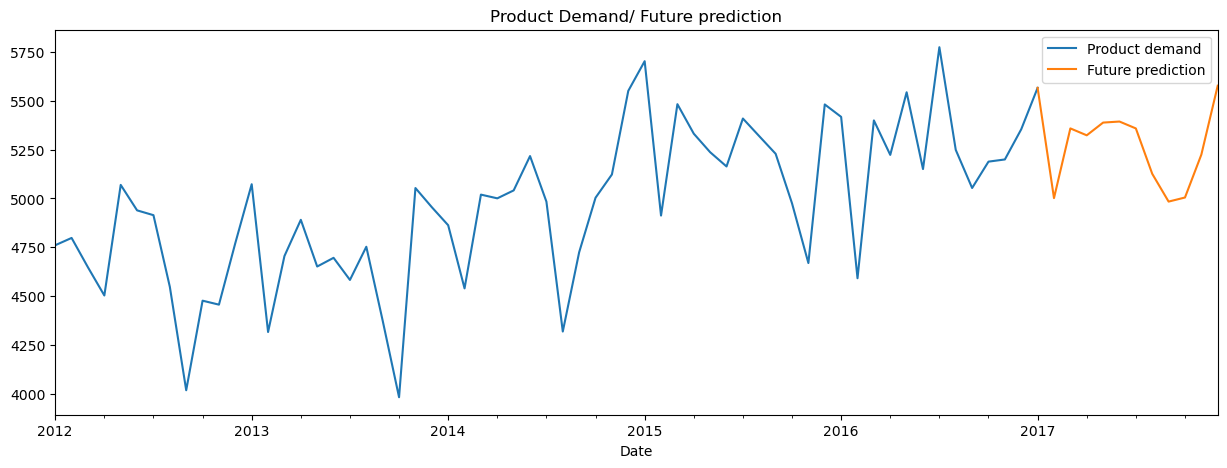

In [94]:
fig, ax = plt.subplots(figsize=(15, 5))
df_month.Order_Demand.plot(ax=ax, label='Product Demand', title='Product Demand/ Future prediction')
future.plot(ax=ax, label='Future')
ax.legend(['Product demand', 'Future prediction'])
plt.show()